In [1]:
import pathlib
import skimage
import cv2
import numpy as np
import pandas as pd
from skimage import feature
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
import math
%matplotlib inline  

In [2]:
im_dir = pathlib.Path('F:/device/optics/32w_Realtime_test_5th/2')

In [3]:
temp_li = ['Low Temp', 'High Temp']
x_range = slice(400, 1900)
y_range = slice(400, 1900)
colors_li = [plt.cm.get_cmap('hsv', 30)(i) for i in range(30)]

In [4]:
ch_dict = {
    0: 'CalRed',
    1: 'FAM',
    2: 'Q670',
    3: 'HEX'
}

In [5]:
im_dict = {}
for ch in range(4):
    ch_name = ch_dict[ch]
    im_dict[ch_name] = {}
    for t in range(2):
        im_dict[ch_name][temp_li[t]] = {}
        for c in range(45):
            im_dict[ch_name][temp_li[t]][c] = {}
            fpath = im_dir/f'{c}_{t}_{ch}.jpg'
            im = np.array(Image.open(fpath))
            im_cropped = im[x_range, y_range]

            im_hsv = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2HSV)
            im_gray = im_hsv[:, :, 2]

            thresh = skimage.filters.threshold_otsu(im_gray)
            threshed_im = im_gray > thresh
            im_dict[ch_name][temp_li[t]][c]['thresh'] = threshed_im

            bw = skimage.morphology.closing(threshed_im, skimage.morphology.disk(3))
            bw2 = skimage.morphology.opening(bw, skimage.morphology.disk(3))
            cleared = skimage.segmentation.clear_border(bw2)
            im_labeled = skimage.measure.label(cleared)
            im_dict[ch_name][temp_li[t]][c]['labeled'] = im_labeled
            
            region_raw_dict = {}
            for region in skimage.measure.regionprops(im_labeled, intensity_image=im_gray):
                region_raw_dict[region.area] = region
            im_dict[ch_name][temp_li[t]][c]['regions'] = region_raw_dict
        

In [6]:
result_dict = {}
for temp in temp_li:
    result_dict[temp] = {}
    for ch in ch_dict.values():
        result_dict[temp][ch] = {}

In [7]:
im_dict[ch][temp][44]['regions']

{569: <skimage.measure._regionprops._RegionProperties at 0x1fd92b7cbe0>,
 393: <skimage.measure._regionprops._RegionProperties at 0x1fd92b7c828>,
 207: <skimage.measure._regionprops._RegionProperties at 0x1fd92b7c9e8>,
 3072: <skimage.measure._regionprops._RegionProperties at 0x1fd92b8d208>,
 3725: <skimage.measure._regionprops._RegionProperties at 0x1fd92b8d278>,
 9885: <skimage.measure._regionprops._RegionProperties at 0x1fd92b8d080>,
 9297: <skimage.measure._regionprops._RegionProperties at 0x1fd92b8d198>,
 2829: <skimage.measure._regionprops._RegionProperties at 0x1fd92b8d898>,
 4185: <skimage.measure._regionprops._RegionProperties at 0x1fd92b8d828>,
 8767: <skimage.measure._regionprops._RegionProperties at 0x1fd92b8d6d8>,
 8637: <skimage.measure._regionprops._RegionProperties at 0x1fd92b8d128>,
 2967: <skimage.measure._regionprops._RegionProperties at 0x1fd92b8d240>,
 3671: <skimage.measure._regionprops._RegionProperties at 0x1fd92b8d0b8>,
 3711: <skimage.measure._regionprops._Reg

In [34]:
row = list('ABCD')[::-1]
result_dict = {'well_grid': {}}
for temp in temp_li:
    result_dict['well_grid'][temp] = {}

for ch in ch_dict.values():
    for temp in temp_li:
        regions = im_dict[ch][temp][44]['regions']
        
        areas_li = []
        for area, region in regions.items():
            areas_li.append(area)
            
        sorted_region_key = list(areas_li)
        sorted_region_key.sort(reverse=True)
        
        minr_li = []
        minc_li = []
        maxr_li = []
        maxc_li = []
        for key in sorted_region_key[:16]:
            region = regions[key]
            minr, minc, maxr, maxc = region.bbox
            minr_li.append(minr)
            minc_li.append(minc)
            maxr_li.append(maxr)
            maxc_li.append(maxc)
        minr_li.sort()
        top = minr_li[0]
        minc_li.sort()
        left = minc_li[0]
        maxr_li.sort()
        bottom = maxr_li[-1]
        maxc_li.sort()
        right = maxc_li[-1]

        well_box = [top-50, left-50, bottom+50, right+50]
        y_li = np.linspace(well_box[0], well_box[2], 5, endpoint=True)
        x_li = np.linspace(well_box[1], well_box[3], 5, endpoint=True)
        pts_x = []
        pts_y = []
        for x in x_li:
            for y in y_li:
                pts_x.append(x)
                pts_y.append(y)
        pts_li = list(zip(pts_x, pts_y))
        
        i = 0
        well_location_dict = {}
        for x in range(4):
            for y in range(4):
                key = row[y]+str(x+1)
                top_left_pt = pts_li[i+y+x]
                bottom_right_pt = pts_li[i+y+x+6]
                well_location_dict[key] = [top_left_pt[1], top_left_pt[0], bottom_right_pt[1], bottom_right_pt[0]]
            i += 4
        result_dict['well_grid'][temp][ch] = well_location_dict
        
            

In [35]:
result_dict['well_grid']['High Temp']['Q670']

{'D1': [141.0, 379.0, 377.0, 606.75],
 'C1': [377.0, 379.0, 613.0, 606.75],
 'B1': [613.0, 379.0, 849.0, 606.75],
 'A1': [849.0, 379.0, 1085.0, 606.75],
 'D2': [141.0, 606.75, 377.0, 834.5],
 'C2': [377.0, 606.75, 613.0, 834.5],
 'B2': [613.0, 606.75, 849.0, 834.5],
 'A2': [849.0, 606.75, 1085.0, 834.5],
 'D3': [141.0, 834.5, 377.0, 1062.25],
 'C3': [377.0, 834.5, 613.0, 1062.25],
 'B3': [613.0, 834.5, 849.0, 1062.25],
 'A3': [849.0, 834.5, 1085.0, 1062.25],
 'D4': [141.0, 1062.25, 377.0, 1290.0],
 'C4': [377.0, 1062.25, 613.0, 1290.0],
 'B4': [613.0, 1062.25, 849.0, 1290.0],
 'A4': [849.0, 1062.25, 1085.0, 1290.0]}

In [36]:
def get_well_loc(x, y, pts_center, well_location_dict):
    for well in well_location_dict.keys():
        y_min, x_min, y_max, x_max = well_location_dict[well]
        if y_min < y < y_max and x_min < x < x_max:
            radius = (x_max-x_min)/2 - 50
            pts_given = np.array([x, y])
            distance = np.linalg.norm(pts_given-pts_center)
            if distance < radius:
                return well

In [37]:
def get_grid_loc(x, y, well_location_dict):
    for well in well_location_dict.keys():
        y_min, x_min, y_max, x_max = well_location_dict[well]
        if y_min < y < y_max and x_min < x < x_max:
            return well

In [38]:
result_dict['well_grid']['High Temp']['Q670']['D1']

[141.0, 379.0, 377.0, 606.75]

In [39]:
t = 1
c = 1

sorted_region_key = list(im_dict['Q670'][temp_li[t]][c]['regions'].keys())
sorted_region_key.sort(reverse=True)

li = []
for key in sorted_region_key:
    region_obj = im_dict['Q670'][temp_li[t]][c]['regions'][key]
    y, x = region_obj.centroid
    li.append([x, y])
li.sort()
    

In [40]:
li

[[107.88246628131022, 1051.0040462427746],
 [157.1125, 1143.6333333333334],
 [476.5452884364396, 277.45653876272513],
 [478.4028640223039, 512.5198327208212],
 [481.42970297029706, 750.4853371051391],
 [484.9605653463619, 975.688623276915],
 [708.7993145990405, 277.90322138450995],
 [709.9728134501878, 509.41960293328566],
 [714.2319297240523, 744.7732263916738],
 [714.8593845526799, 966.9599551660892],
 [938.2115933752142, 274.3813535122787],
 [940.7636452639308, 505.12490821571345],
 [944.684776119403, 737.0779104477612],
 [945.1521620738482, 957.6498202810152],
 [1164.7846360783142, 730.6535644896129],
 [1165.2813001020259, 950.8558519166302],
 [1166.4712307887717, 501.55950717642577],
 [1167.51841868823, 265.7190775681342]]

In [41]:
for x, y in li:
    grid = get_grid_loc(x, y, result_dict['well_grid']['High Temp']['Q670'])
    print(grid, '>>>', x, y)

None >>> 107.88246628131022 1051.0040462427746
None >>> 157.1125 1143.6333333333334
D1 >>> 476.5452884364396 277.45653876272513
C1 >>> 478.4028640223039 512.5198327208212
B1 >>> 481.42970297029706 750.4853371051391
A1 >>> 484.9605653463619 975.688623276915
D2 >>> 708.7993145990405 277.90322138450995
C2 >>> 709.9728134501878 509.41960293328566
B2 >>> 714.2319297240523 744.7732263916738
A2 >>> 714.8593845526799 966.9599551660892
D3 >>> 938.2115933752142 274.3813535122787
C3 >>> 940.7636452639308 505.12490821571345
B3 >>> 944.684776119403 737.0779104477612
A3 >>> 945.1521620738482 957.6498202810152
B4 >>> 1164.7846360783142 730.6535644896129
A4 >>> 1165.2813001020259 950.8558519166302
C4 >>> 1166.4712307887717 501.55950717642577
D4 >>> 1167.51841868823 265.7190775681342


In [42]:
region_sum_dict = {}
for t in range(2):
    temp = temp_li[t]
    region_sum_dict[temp] = {}
    for ch in ch_dict.values():
        region_sum_dict[temp][ch] = {}
        for well in well_location_dict.keys():
            region_sum_dict[temp][ch][well] = [0]*45

        for c in range(45):
            sorted_region_key = list(im_dict[ch][temp][c]['regions'].keys())
            sorted_region_key.sort(reverse=True)

            center_at_cycle = {}
            for key in sorted_region_key:
                region_obj = im_dict[ch][temp][c]['regions'][key]
                y, x = region_obj.centroid
                grid = get_grid_loc(x, y, result_dict['well_grid'][temp][ch])
                if 'High' in temp and 'Q' in ch and c == 1:
                    print(grid, x, y)
                if grid is None:
                    continue
            
                if grid not in center_at_cycle.keys():
                    center = [x, y]
                    center_at_cycle[grid] = center
                else:
                    center = center_at_cycle[grid]
                well = get_well_loc(x, y, center, result_dict['well_grid'][temp][ch])

                if well is not None:
                    val = region_sum_dict[temp][ch][well][c]
                    val += region_obj.intensity_image.sum()
                    region_sum_dict[temp][ch][well][c] = val

result_dict['rfu_sum'] = region_sum_dict


C3 940.7636452639308 505.12490821571345
A1 484.9605653463619 975.688623276915
C2 709.9728134501878 509.41960293328566
B1 481.42970297029706 750.4853371051391
B2 714.2319297240523 744.7732263916738
B3 944.684776119403 737.0779104477612
A2 714.8593845526799 966.9599551660892
A3 945.1521620738482 957.6498202810152
C1 478.4028640223039 512.5198327208212
C4 1166.4712307887717 501.55950717642577
D2 708.7993145990405 277.90322138450995
D3 938.2115933752142 274.3813535122787
A4 1165.2813001020259 950.8558519166302
B4 1164.7846360783142 730.6535644896129
None 107.88246628131022 1051.0040462427746
D1 476.5452884364396 277.45653876272513
D4 1167.51841868823 265.7190775681342
None 157.1125 1143.6333333333334


In [43]:
ch_dict.values()

dict_values(['CalRed', 'FAM', 'Q670', 'HEX'])

In [44]:
dict_before = pd.read_excel('F:/device/optics/32w_Realtime_test_5th/5차 2번카메라.xlsx', sheet_name=None, header=None)
dict_before.keys()

odict_keys(['fam60', 'hex60', 'cal60', 'qua60', 'fam72', 'hex72', 'cal72', 'qua72'])

In [45]:
df = dict_before['fam60']
df

0       1       2       3       4       5       6       7       8   \
0   45841  122714  115249   47317  159241  354639  360273  159439  217330   
1   43353  116732  112159   46362  149806  338644  352249  158645  205554   
2   45011  122730  114589   46271  150569  342402  353387  160476  204505   
3   43897  124110  117059   45744  147735  339499  351869  161300  199116   
4   43311  123093  116435   44464  144758  335128  350619  160355  196681   
5   31191   98474   99840   37459  124177  307261  323422  151217  183874   
6   31628  105131  101799   37672  122126  303434  321620  152215  182142   
7   30875  103588  102367   37854  121517  303578  320172  153096  179439   
8   30402  104079  103481   37183  120726  300185  318065  151311  178150   
9   29934  103800  104377   35991  119772  299734  318194  152334  176492   
10  29293  102885  104478   34589  117247  298880  317068  151771  175497   
11  29647  102049  103796   33380  117223  296149  317512  151649  173169   
12  29922  102939  106518   34482  116100  295130  314883  151220  174100   
13  29666  100954  106761   33680  115127  292644  312467  149898  173124   
14  29096  101773  106813   33765  115023  292895  310190  147951  171816   
15  28806  100342  107214   33782  114039  291975  312184  149547  170679   
16  27884  100425  106361   33221  112331  287501  307732  148870  171159   
17  27588  100437  106970   33886  111896  287728  307865  147905  169649   
18  27765   99110  108314   33348  112520  286749  307214  149026  168287   
19  27647  100504  107134   34013  110913  286731  305908  147854  168411   
20  27044   98627  105557   33808  109961  283909  304754  146834  166088   
21  27406   94256  104612   34147  110547  283073  303956  146528  166944   
22  27284   93584  105242   33998  109430  281012  303709  146317  165594   
23  27928   92691  106548   34067  108535  281946  301988  146010  167387   
24  27420   94055  104756   34815  108640  280270  302645  143403  165775   
25  26724   91330  104926   34162  108272  278595  300995  143729  163441   
26  26793   93011  104515   33816  107918  277802  299252  143817  164154   
27  27155   92279  104131   34033  108233  279409  303195  143488  164183   
28  26296   93090  105036   33632  108323  279046  301134  143431  163945   
29  26441   93664  105619   34955  108295  280049  304676  144730  164209   
30  26597   94107  107341   35053  108669  280838  308246  146718  164415   
31  27154   95531  109732   35454  110515  285669  314304  151203  166526   
32  27695   98610  112691   36757  111748  289476  322809  154831  169670   
33  28846  100972  119491   38929  116747  300360  336877  162557  173696   
34  29847  105139  124283   40707  121137  309467  345679  167746  181549   
35  31804  115376  132316   43473  124683  322059  361691  178486  186866   
36  33901  122465  138858   46909  135056  336194  379886  187257  198125   
37  36707  132742  150134   51254  141770  354307  403731  198111  205635   
38  36388  143986  168619   65703  145983  386086  452858  229784  214699   
39  41066  158039  182936   72926  158607  412113  483222  247717  227118   
40  46620  174309  198071   80013  173168  441800  514001  265386  241679   
41  56928  200979  230864   97650  202536  496174  573760  303142  279821   
42  63025  215882  248103  107564  216563  521270  599146  322193  298733   
43  68074  225932  261414  114369  229829  542243  622186  337259  313804   

        9       10      11      12      13      14      15  
0   411200  387879  173026  151721  316275  317554  185391  
1   399409  386515  176443  150016  319358  322322  188086  
2   402995  378857  174305  151727  320317  323005  184624  
3   399747  377233  175199  151718  323114  325385  186847  
4   396073  376349  173881  151105  321844  324471  188692  
5   381807  384910  175358  150932  332446  337118  195266  
6   381293  390261  174429  148718  331193  336435  193579  
7   380587  389988  174696  149942  335531  338766  1

In [46]:
len(df)

44

In [47]:
map_dict = {
    'CalRed': 'cal',
    'FAM': 'fam',
    'HEX': 'hex',
    'Q670': 'qua',
    'L': '60',
    'H': '72'
}
row = list('ABCD')[::-1]
col_li = []
for y in range(4):
    for x in range(4):
        key = row[y]+str(x+1)
        col_li.append(key)
col_li

['D1',
 'D2',
 'D3',
 'D4',
 'C1',
 'C2',
 'C3',
 'C4',
 'B1',
 'B2',
 'B3',
 'B4',
 'A1',
 'A2',
 'A3',
 'A4']

In [48]:
result_dict['rfu_sum']['Low Temp'].keys()

dict_keys(['CalRed', 'FAM', 'Q670', 'HEX'])

In [49]:
pd.DataFrame(result_dict['rfu_sum']['High Temp']['Q670'])

D1      C1      B1      A1      D2      C2      B2      A2      D3  \
0    69759  178387  263807  247127  160252  287990  268540  246991  140778   
1    71311  176124  259748  267605  163166  285698  271551  250568  147910   
2    72249  173043  251508  275291  168343  287291  273882  257878  152548   
3    70990  173020  249367  291026  166242  287893  274765  274896  156193   
4    68961  147926  205683  190164  169084  283054  270228  213436  164043   
5    85661  153418  207955  192212  199051  299392  288491  224037  189574   
6    71795  141307  198887  187260  177250  285729  289348  222333  169834   
7    71370  139037  196570  187008  185341  285452  289093  229946  169732   
8    86345  145626  202231  204785  210834  289932  289566  233081  203308   
9    69458  137319  194059  198236  183396  280355  288290  232541  175401   
10   68583  135849  193659  199053  182788  278295  286341  231997  186612   
11   69371  133082  191620  200526  186496  280167  285900  238428  188464   
12   82217  139976  193332  205198  208378  283597  282444  233393  219868   
13   70475  128935  186799  194389  187138  281085  276987  227290  194133   
14   86544  139451  190331  206395  212118  285363  279310  233567  223640   
15   64760  126614  184206  199807  181966  272577  275844  231216  187038   
16   66958  127294  183072  199142  179803  274720  273396  235939  190234   
17   63210  126103  186632  192835  181048  274538  272371  232687  191618   
18   64231  127603  183450  204268  181994  273127  269312  237516  191704   
19   63632  124870  182633  198495  175524  270961  269061  232642  194314   
20   67557  126421  178038  200065  179371  271894  269101  236756  193399   
21   73482  125273  180039  197985  185936  273232  269163  233664  203706   
22   66741  124135  178885  195968  181590  270140  267207  233300  196057   
23   71938  133584  188609  213296  192099  271876  260010  241494  214586   
24   76589  132432  185473  215140  188121  274426  259254  238721  211329   
25   75655  134438  189870  211894  193923  274304  262225  238383  213923   
26   70170  134264  186413  218280  188495  272459  260233  243180  211946   
27   69988  131795  183703  216792  190069  273272  259682  241564  210912   
28   71152  133596  186576  212545  193736  277202  263958  237821  216148   
29   73494  131068  189309  215549  193316  282165  262337  243409  218634   
30   75706  133421  191024  213828  195392  283902  269103  243174  224972   
31   74517  141063  195999  222255  200134  290937  278046  246803  232019   
32   83011  150848  199541  227535  213104  301802  290016  258179  243544   
33   87517  160762  216338  240462  221867  320808  310299  276187  253499   
34   87358  155962  213417  235029  218379  321860  319179  274755  254308   
35   99592  172787  230936  243134  246239  346863  341433  286717  264945   
36   87658  171887  222398  241615  238389  348531  352071  296343  274289   
37  100078  192823  254039  266774  257137  376605  388526  314263  292787   
38  109643  208287  275399  287829  286880  428064  430889  351904  326746   
39  123131  229737  294271  308353  316093  457050  456977  377026  351054   
40  115795  234423  308632  317572  299401  466283  478060  392246  324982   
41  143054  254171  327856  335543  341344  490375  488436  406443  369611   
42  149054  263051  332600  350403  346545  497608  493816  417942  376837   
43  154089  277436  346930  359358  359722  511416  496340  426452  384902   
44  134807  276053  351101  371275  336999  510020  503455  446232  352278   

        C3      B3      A3      D4      C4      B4      A4  
0   315812  252038  241321   60727  181075  156791  177559  
1   313073  252318  249929   58610  184892  160669  178363  
2   315456  251956  250889   62794  188776  156089  174209  
3   316297  251813  252162   60608  186378  160094  178609  
4   290565  224788  208597   72704  169766  135223  154407  
5   309047  247200  213442   86936  179105  141082  1

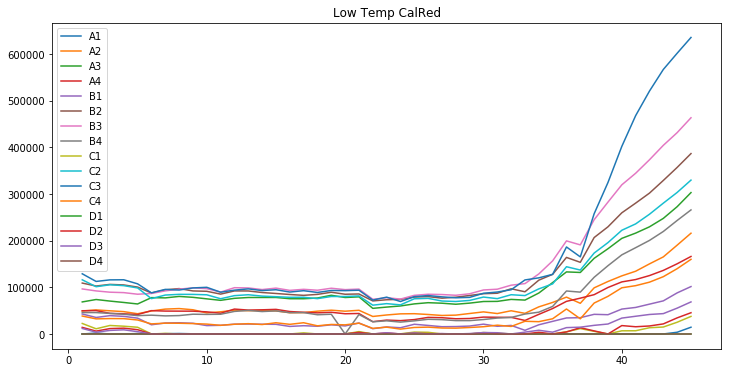

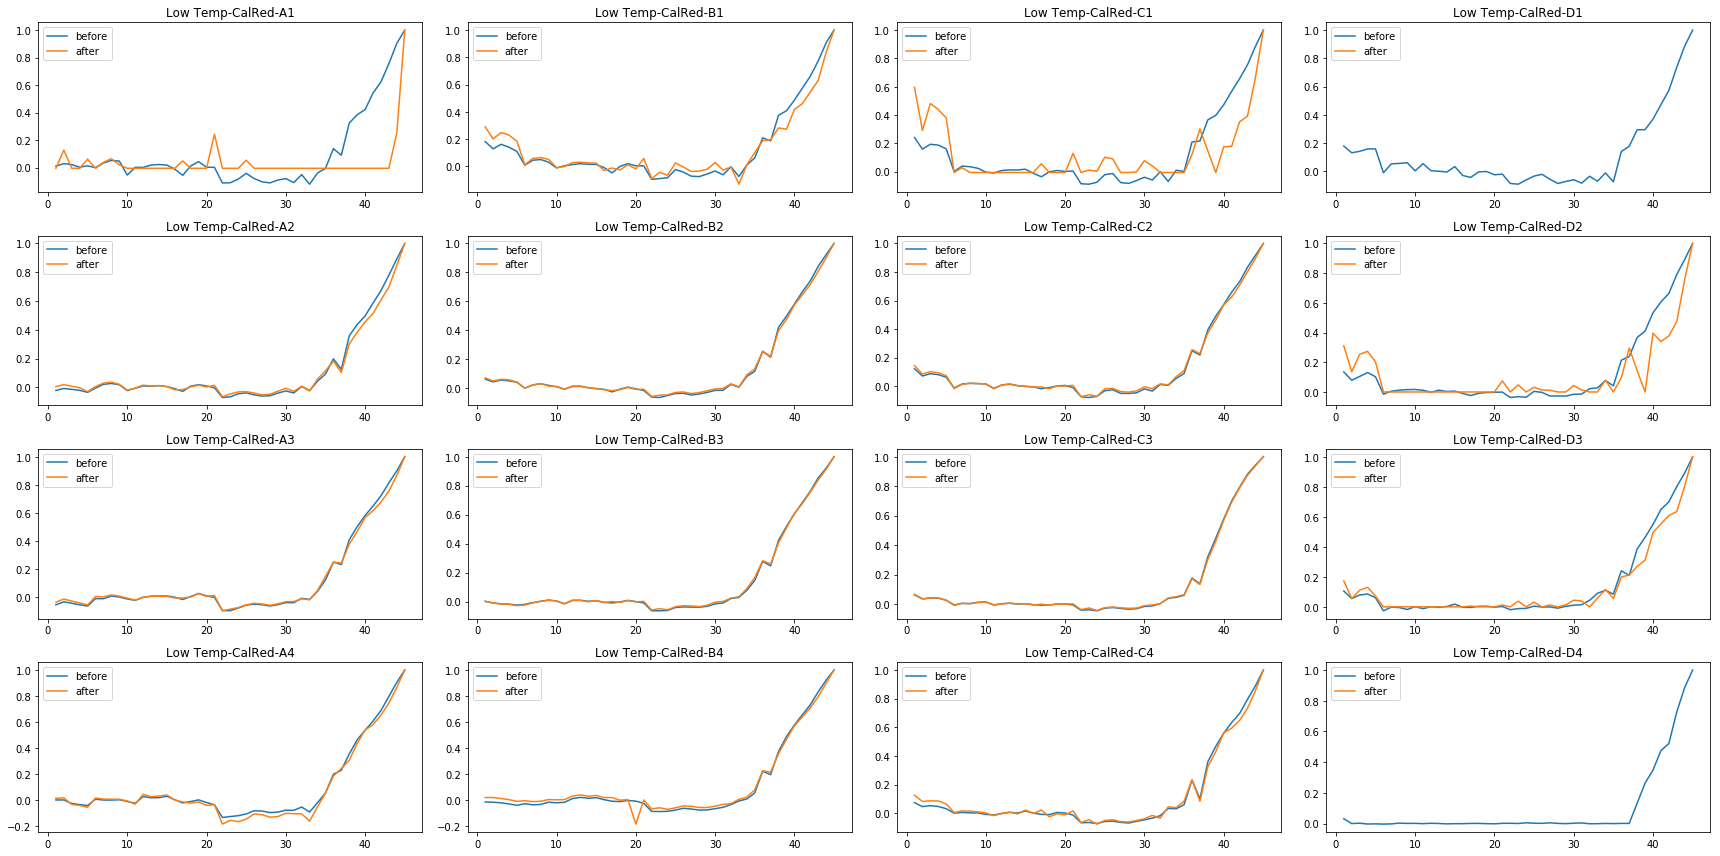

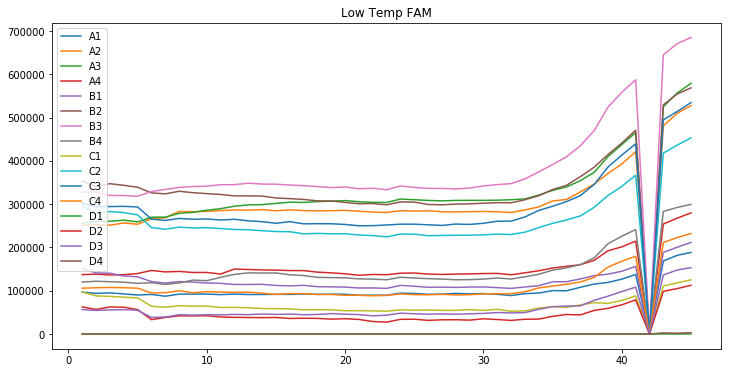

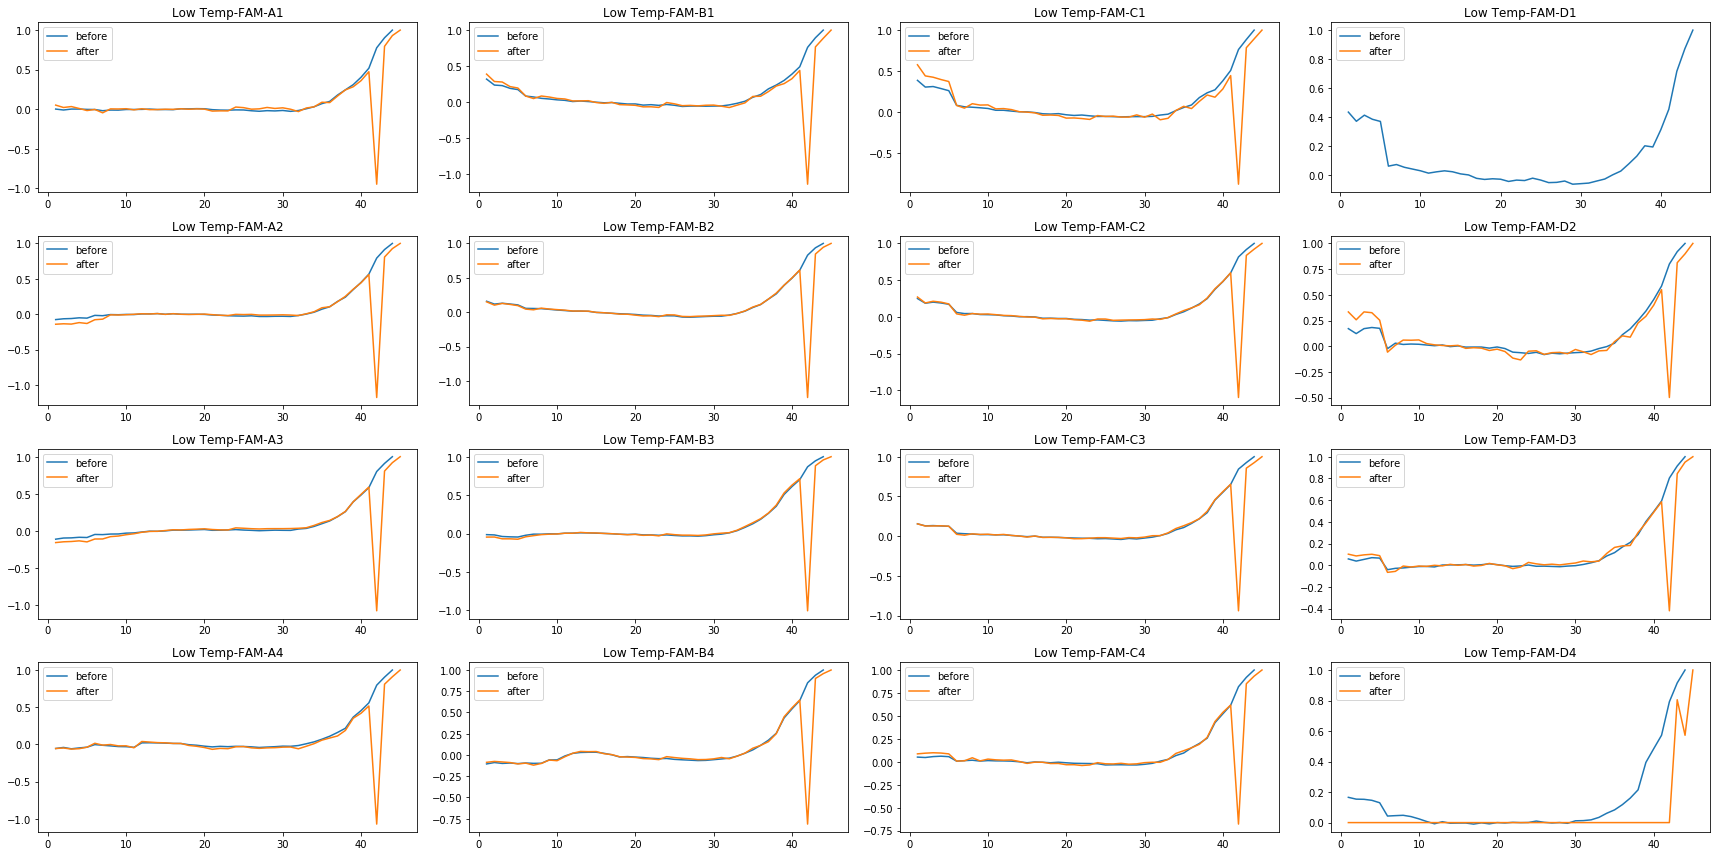

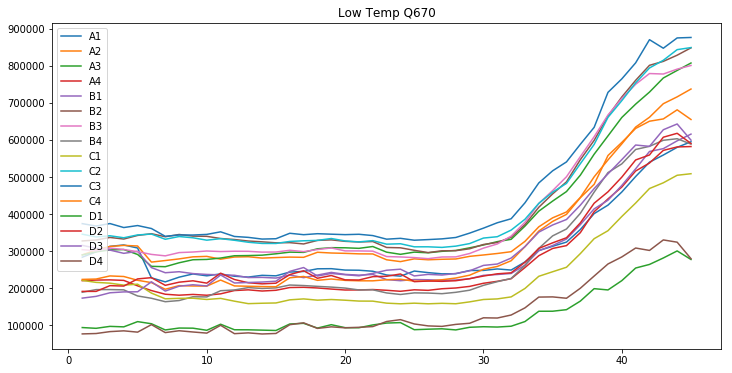

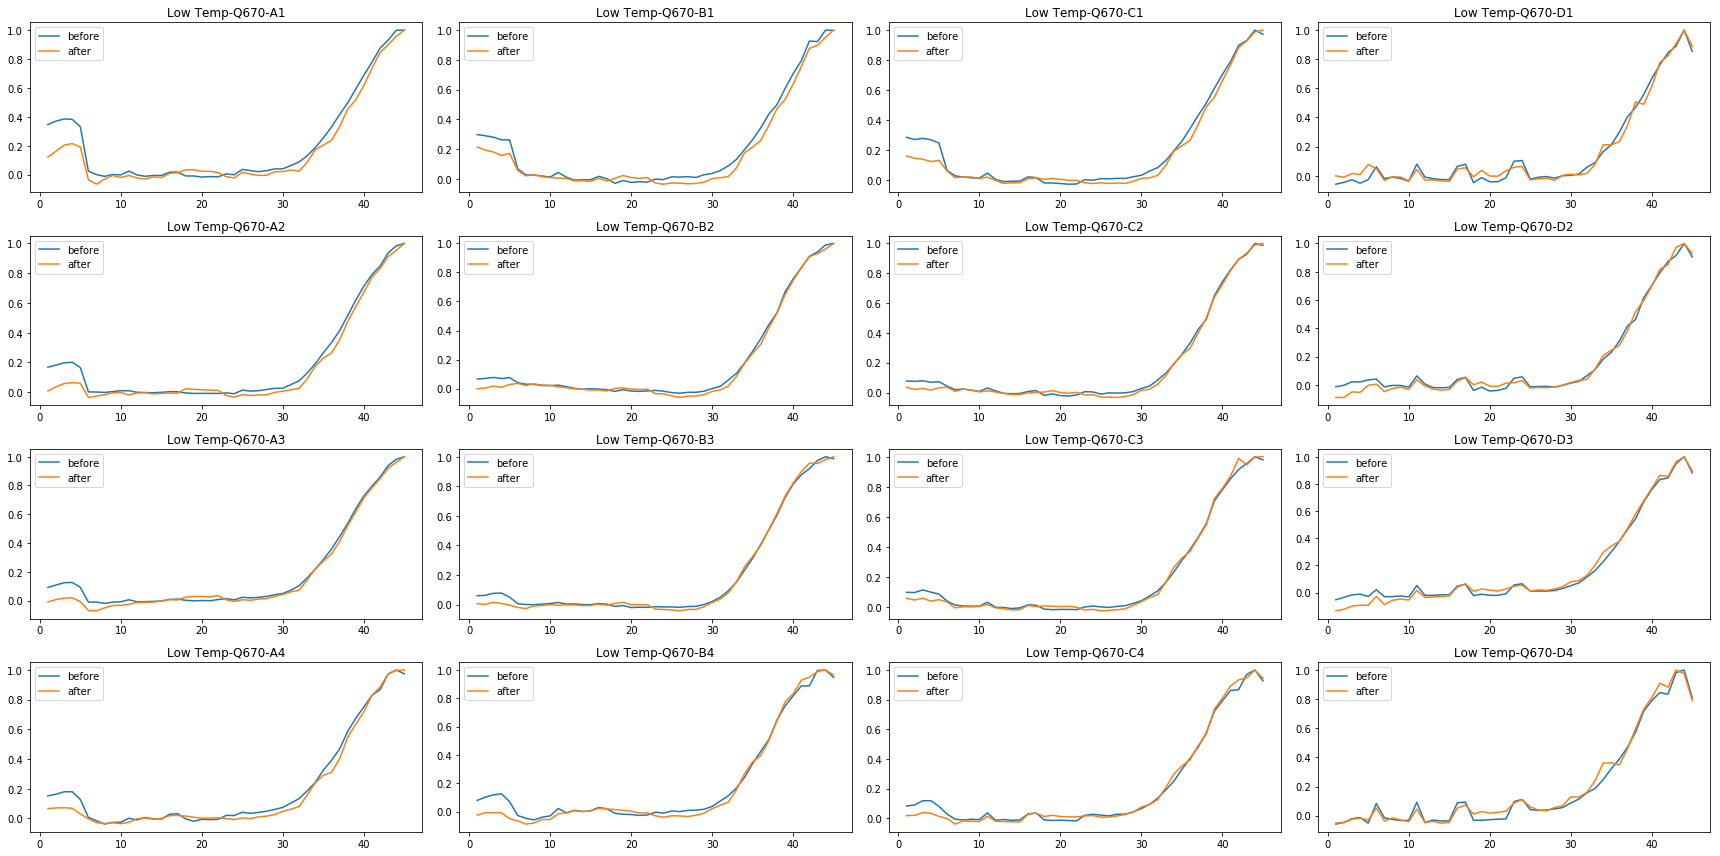

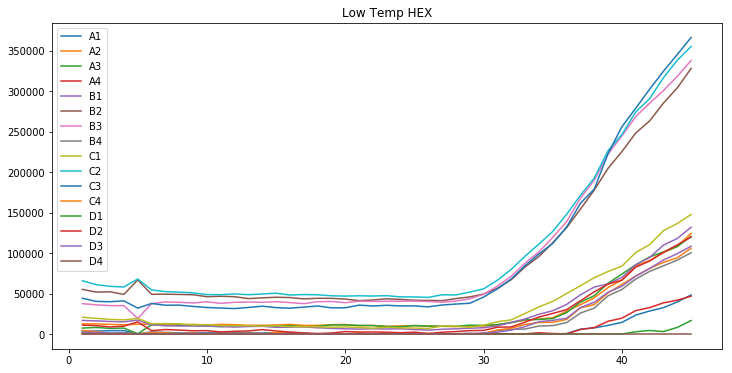

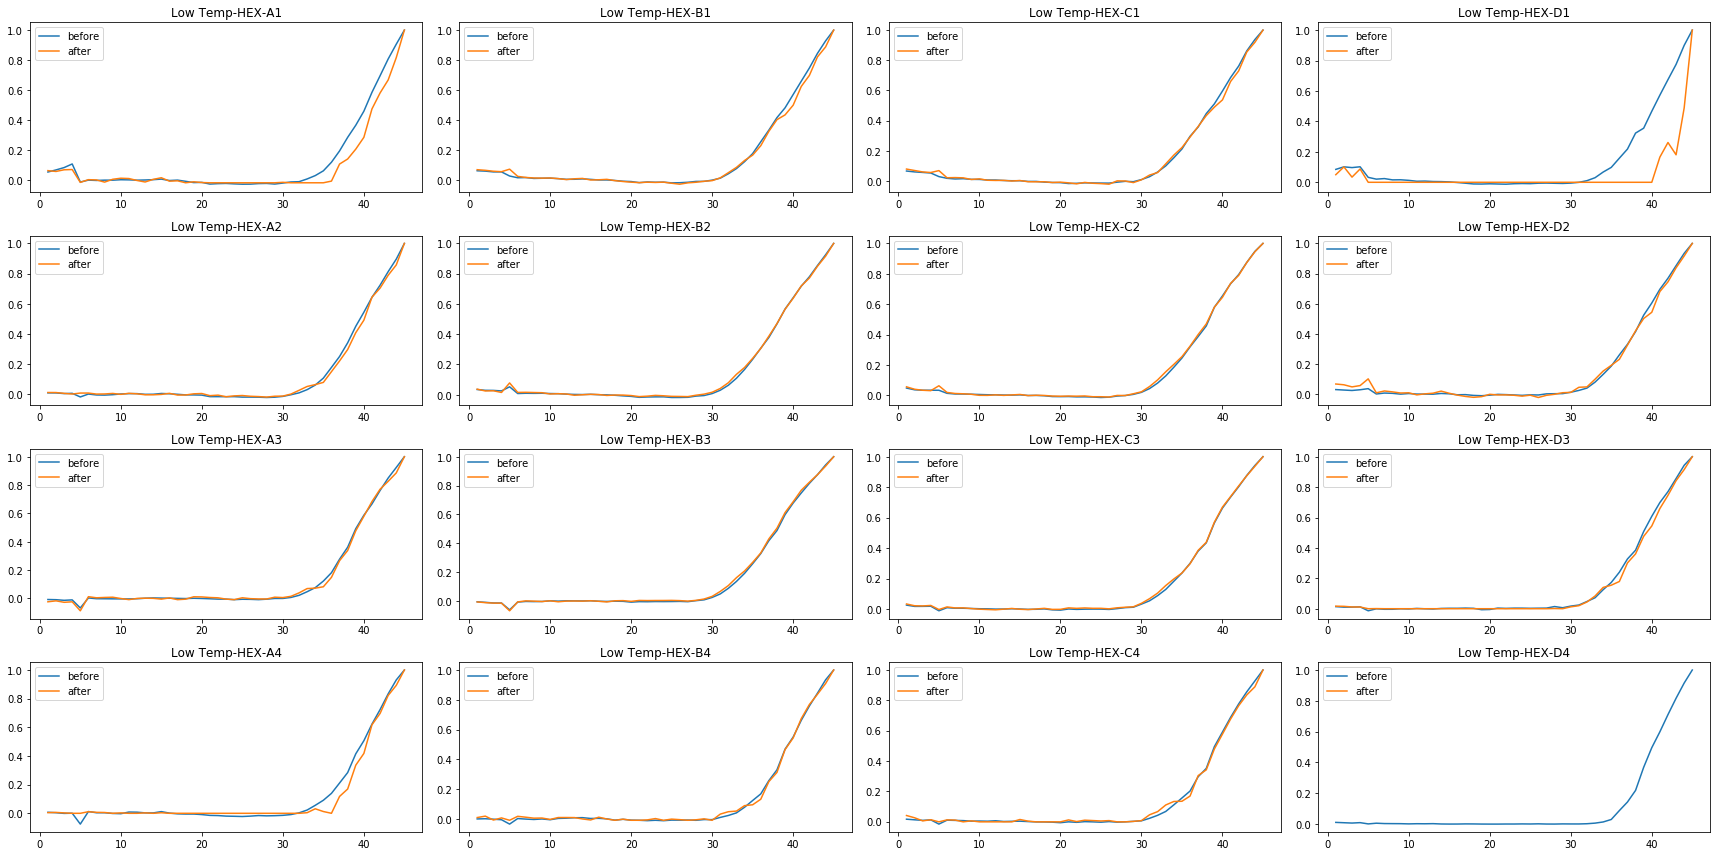

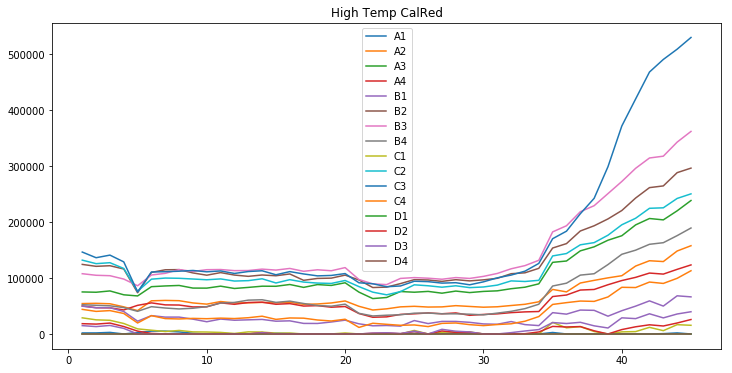

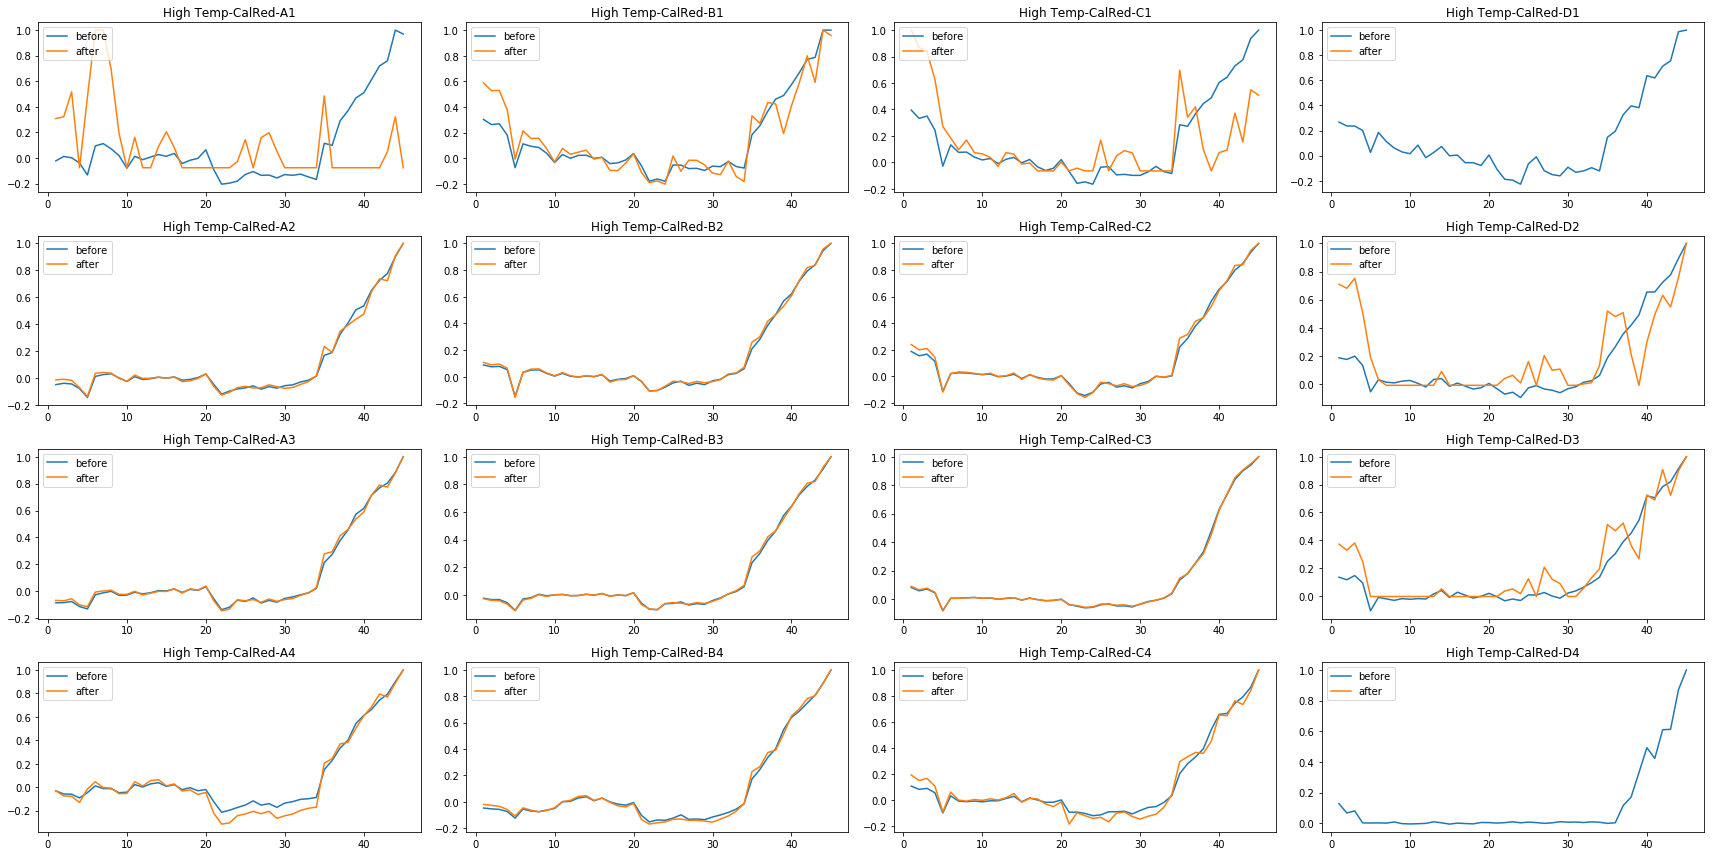

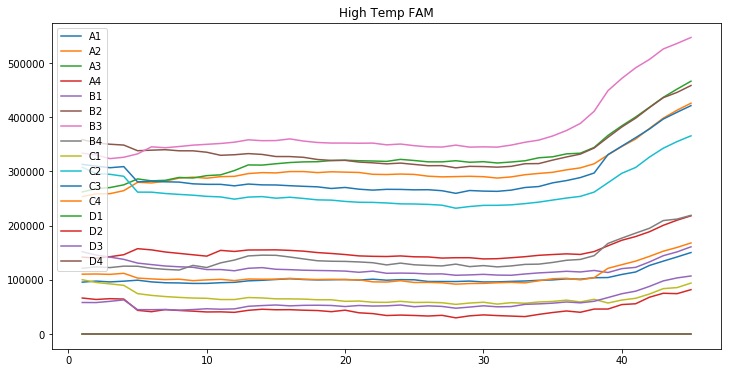

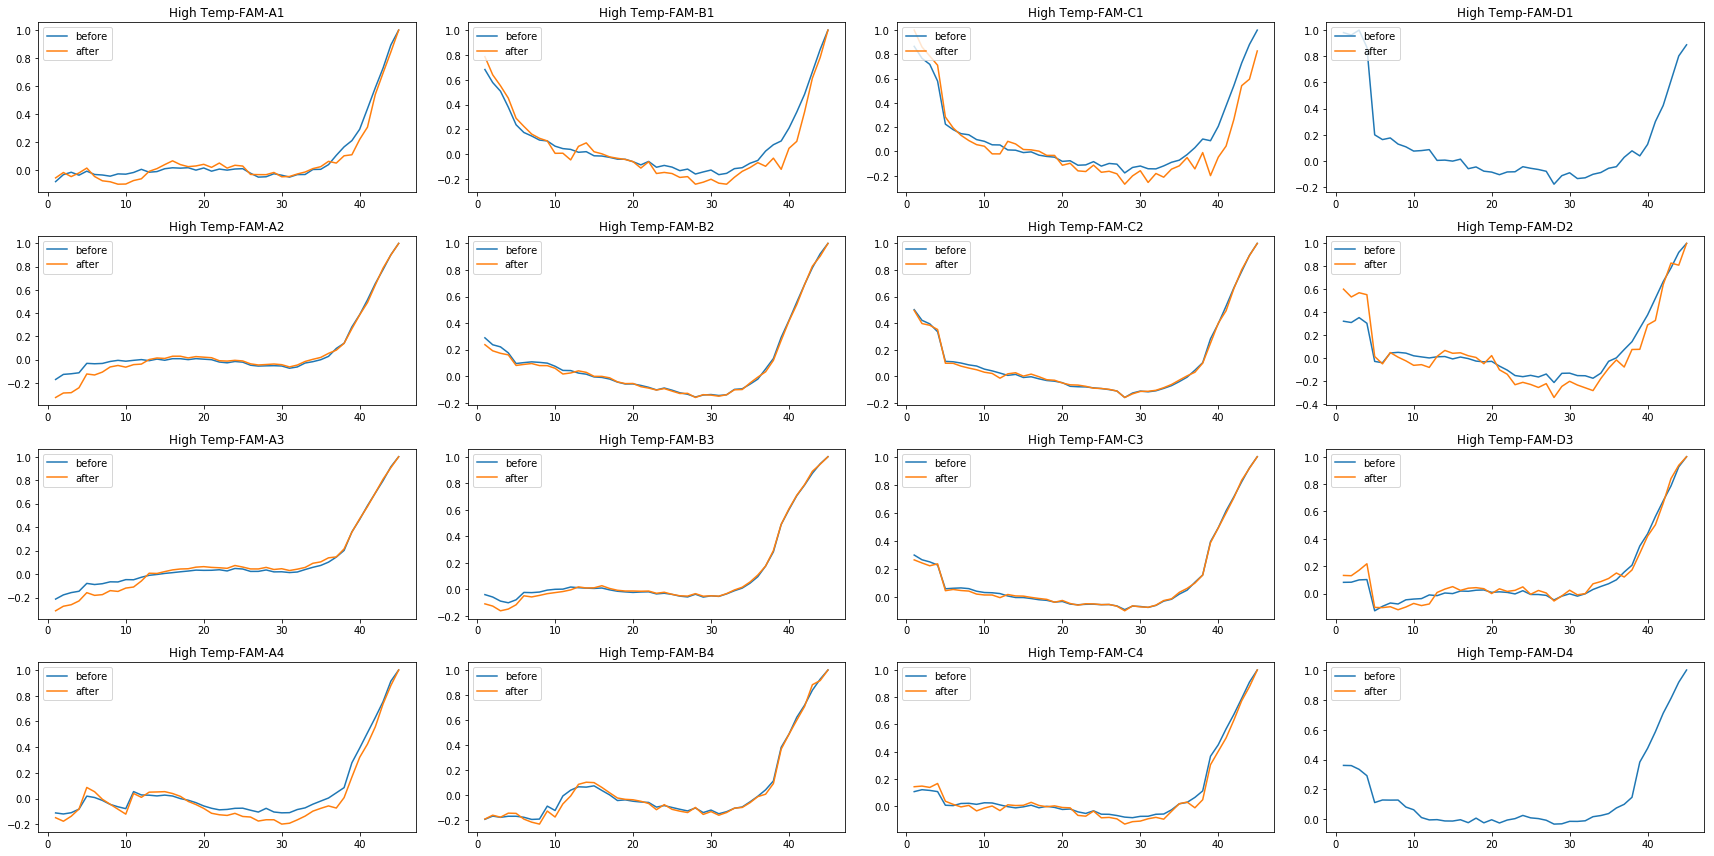

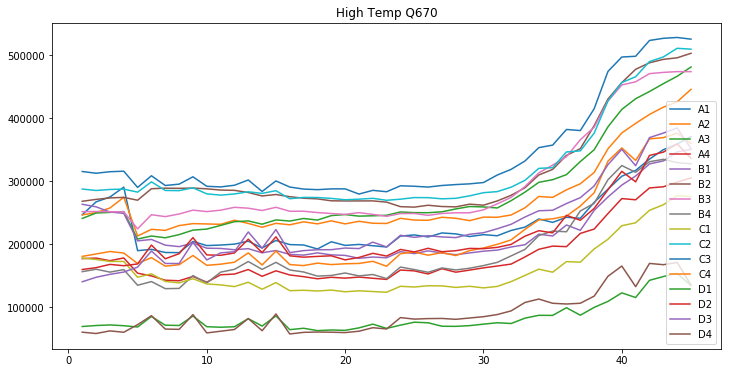

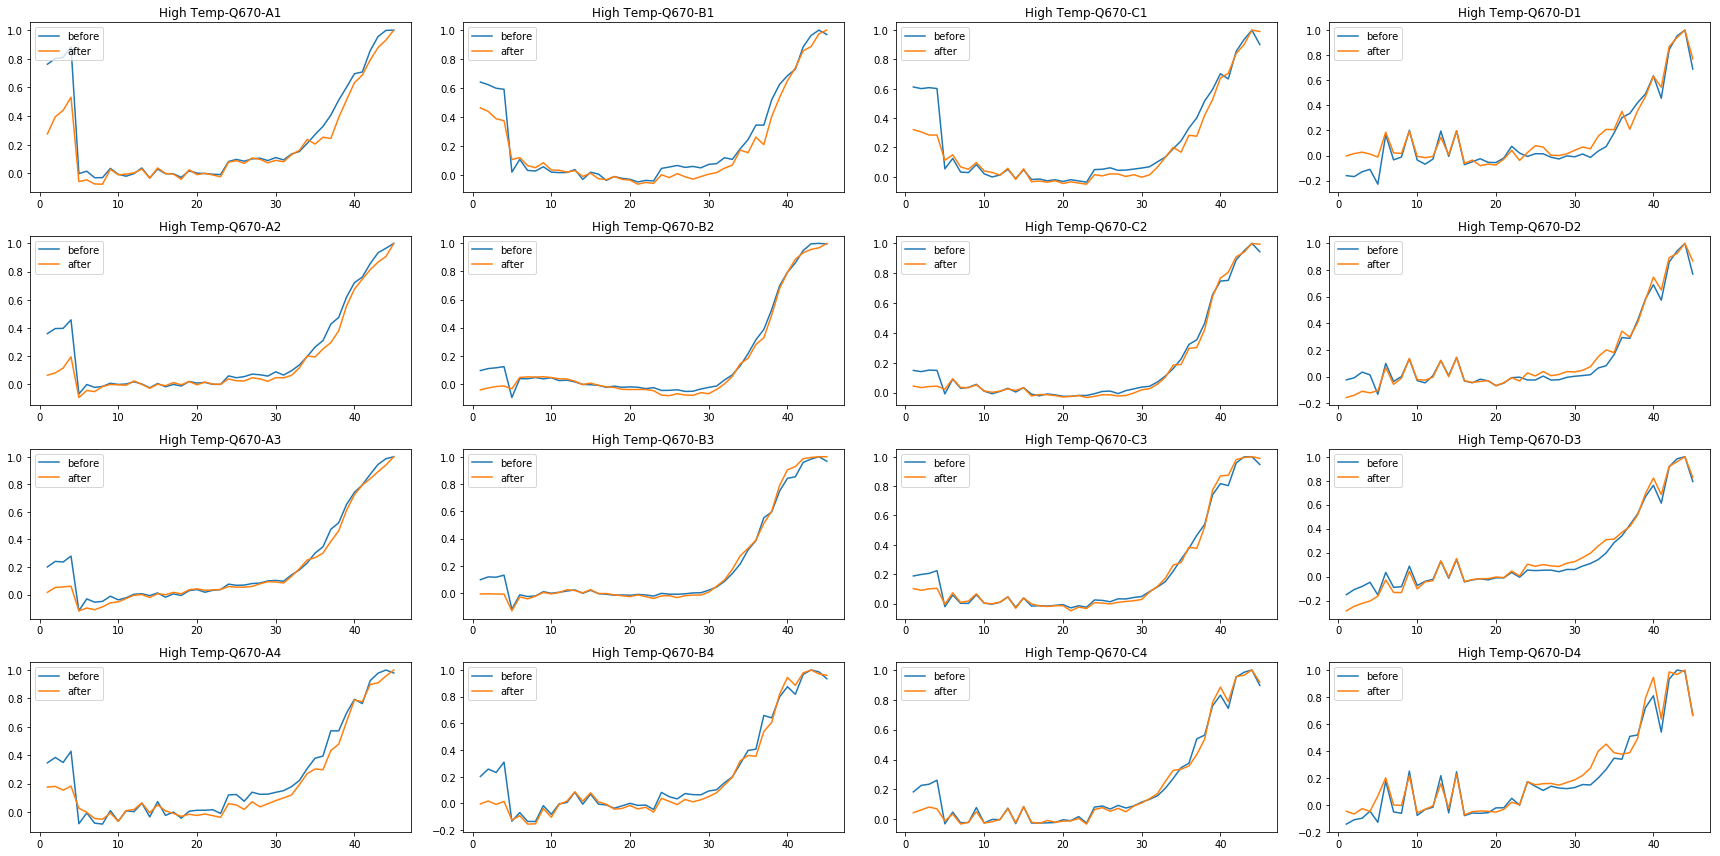

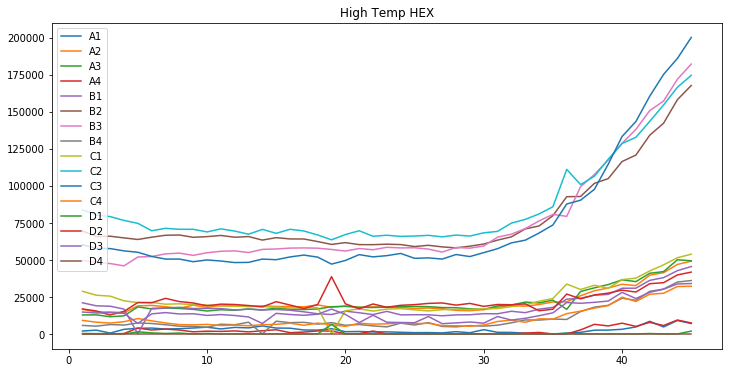

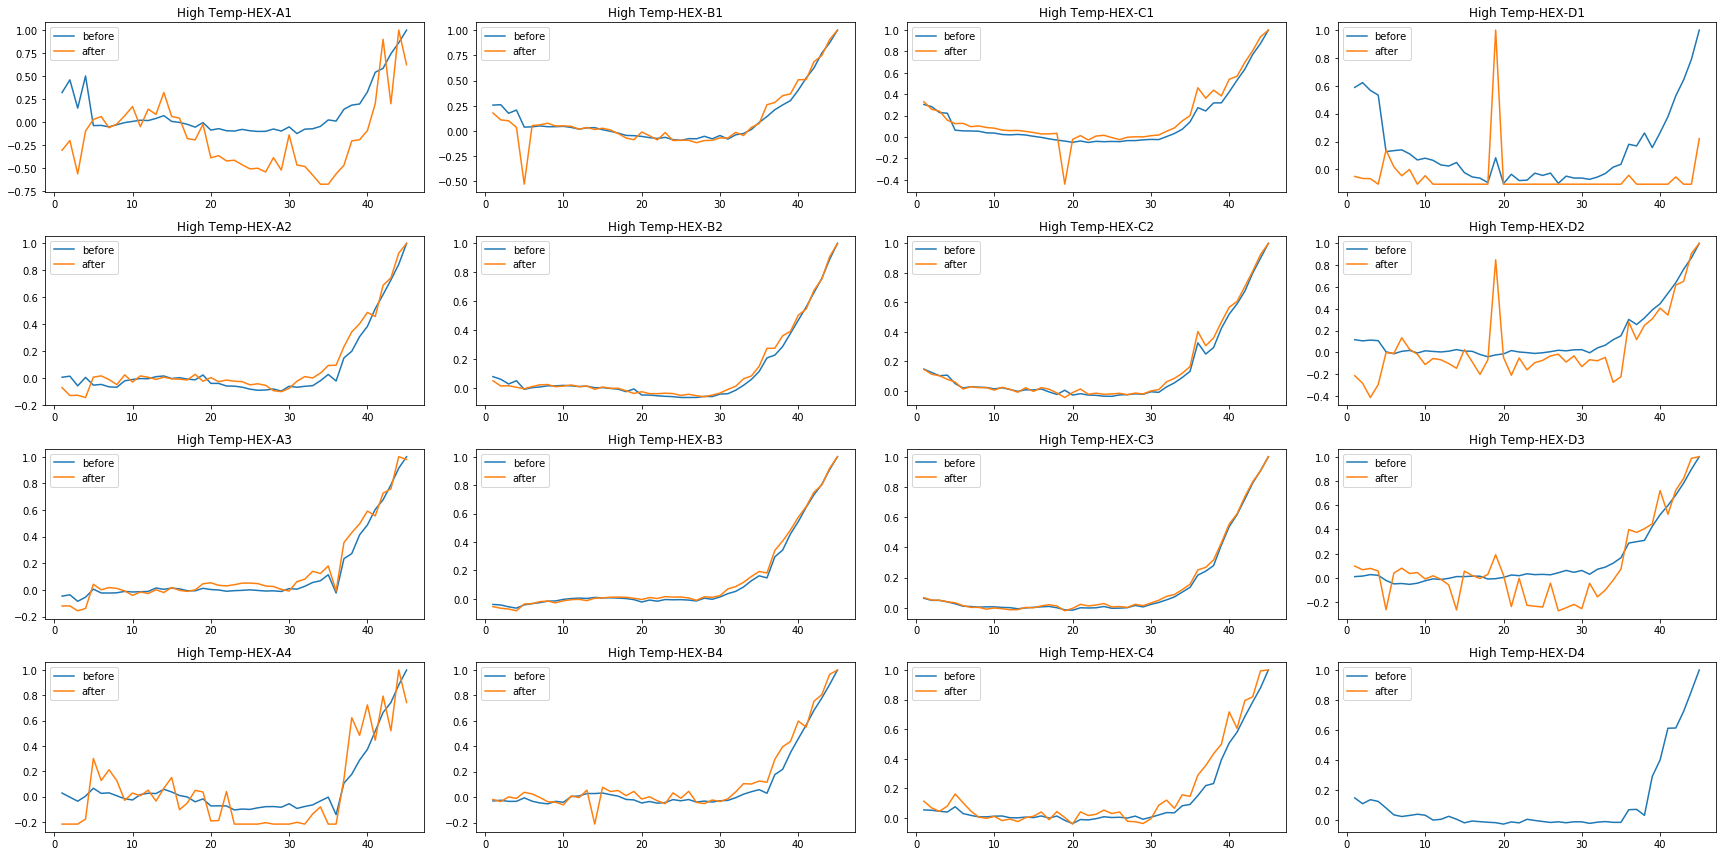

In [50]:
for temp in result_dict['rfu_sum'].keys():
    for ch, _dict in result_dict['rfu_sum'][temp].items():
        df = pd.DataFrame(_dict)
        df.index = range(1, 46)
        df = df.reindex(sorted(df.columns), axis=1)
        fig = df.plot(figsize=(12, 6), title=f'{temp} {ch}').get_figure()
        fig.savefig(f'{temp}_{ch}.png')
        
        key_before = map_dict[ch]+map_dict[temp[0]]
        df_before = dict_before[key_before]
        df_before.columns = col_li
        df_before.index = range(1, len(df_before)+1)
        
        df_before_norm = (df_before - df_before.loc[10:20].mean())/(df_before.max()-df_before.loc[10:20].mean())
        df_norm = (df-df.loc[10:20].mean())/(df.max()-df.loc[10:20].mean())
        
        fig, axes = plt.subplots(4, 4, figsize=(24, 12))
        n = 0
        for col in df_norm.columns:
            i = n%4
            j = n//4
            axes[i, j].plot(df_before_norm[col], label='before')
            axes[i, j].plot(df_norm[col], label='after')
            axes[i, j].set_title(f'{temp}-{ch}-{col}')
            n += 1
            axes[i, j].legend(loc='upper left')
        plt.tight_layout()
        plt.savefig(f'camera2_hsv_otsu_compare_{temp}_{ch}.png')

# investigate High Q670

In [32]:
import matplotlib.patches as _patches

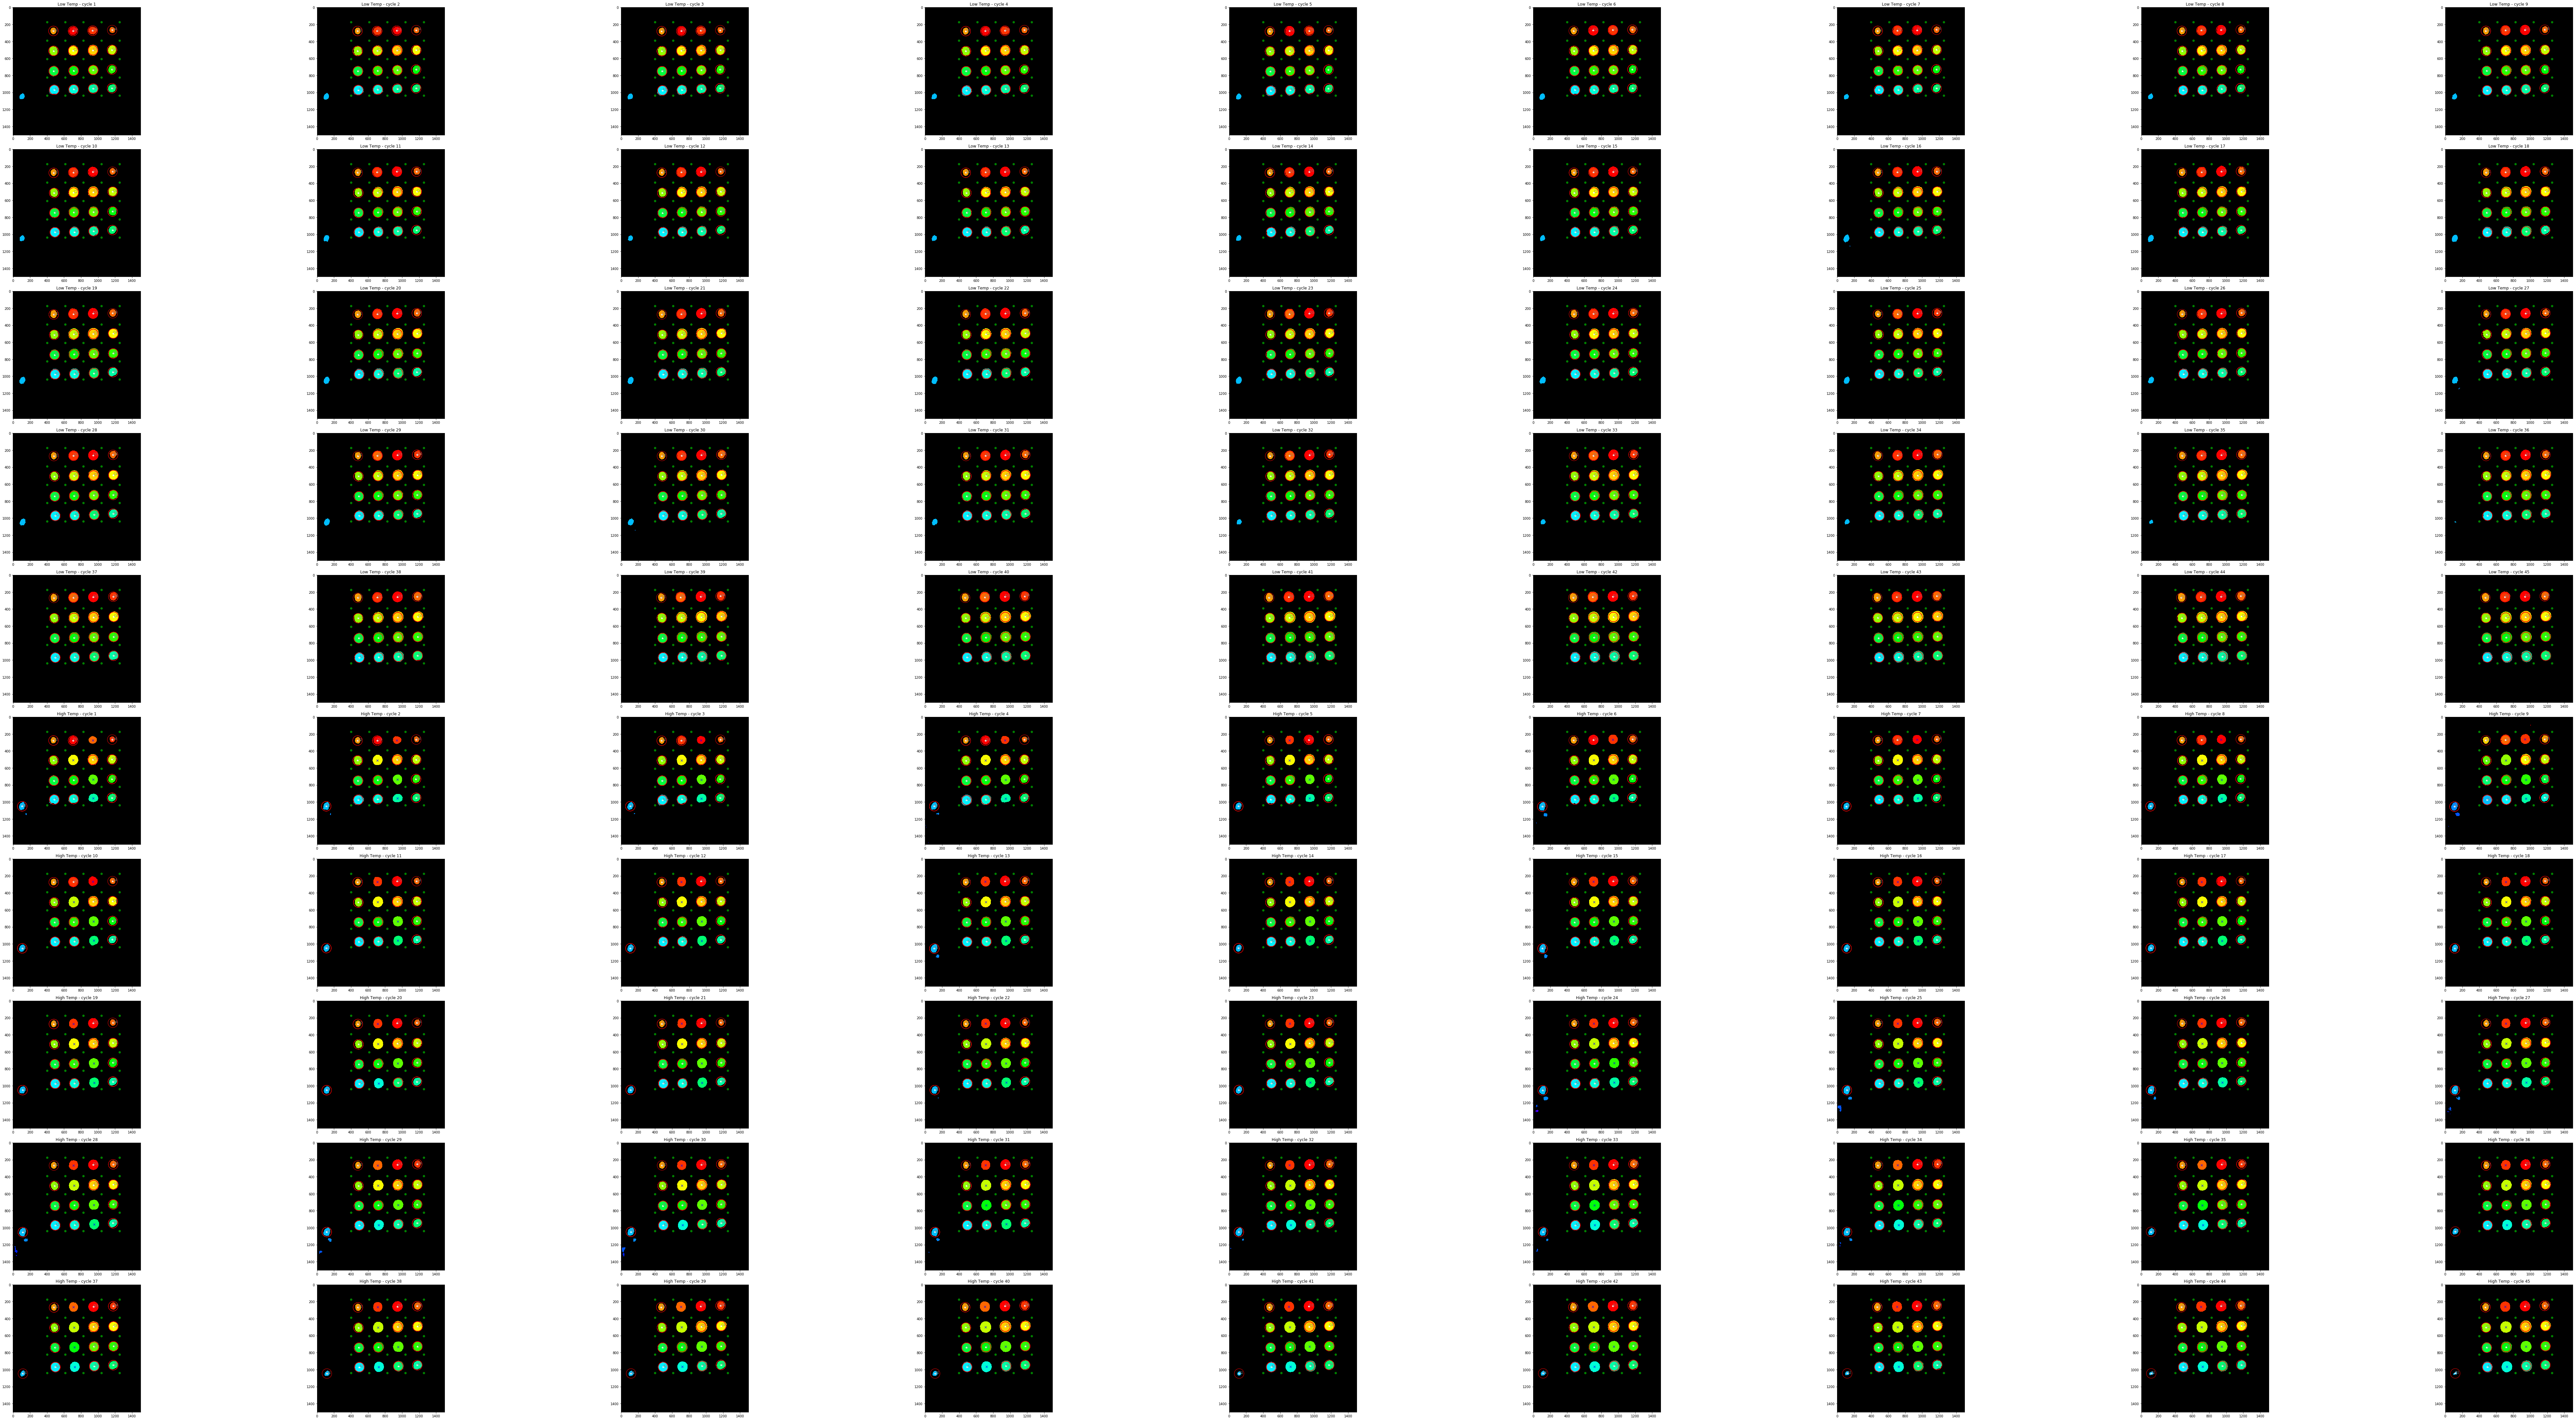

In [33]:
fig, ax = plt.subplots(10, 9, figsize=(24*5, 12*5))            
region_intensity_dict = {}
for t in range(2):
    region_intensity_dict[temp_li[t]] = {}
    for well in well_location_dict.keys():
        region_intensity_dict[temp_li[t]][well] = [0]*45
        
    for c in range(45):
        im_labeled = im_dict['Q670'][temp_li[t]][c]['labeled']
        image_label_overlay = skimage.color.label2rgb(im_labeled, bg_label=0, colors=colors_li)
        ax_x_coord = c//9+(t*5)
        ax_y_coord = c%9
        
        ax[ax_x_coord, ax_y_coord].imshow(image_label_overlay)
        ax[ax_x_coord, ax_y_coord].set_title(f'{temp_li[t]} - cycle {c+1}')
        ax[ax_x_coord, ax_y_coord].scatter(pts_x, pts_y, c='g')
        
        sorted_region_key = list(im_dict['Q670'][temp_li[t]][c]['regions'].keys())
        sorted_region_key.sort(reverse=True)
                
        center_at_cycle = {}
        circle_li = []
        for key in sorted_region_key:
            region_obj = im_dict['Q670'][temp_li[t]][c]['regions'][key]
            y, x = region_obj.centroid
            grid = get_grid_loc(x, y, result_dict['well_grid'][temp_li[t]]['Q670'])
            if grid is None:
                continue
            
            if grid not in center_at_cycle.keys():
                center = [x, y]
                center_at_cycle[grid] = center

                y_min, x_min, y_max, x_max = well_location_dict[grid]
                grid_center_x = (x_max-x_min)/2 + x_min
                rad = grid_center_x - x_min - 50
                circle_li.append(_patches.Circle(center, radius=rad, color='r', fill=False, linewidth=1))
            else:
                center = center_at_cycle[grid]
            well = get_well_loc(x, y, center, result_dict['well_grid'][temp_li[t]]['Q670'])

            if well is not None:
                val = region_intensity_dict[temp_li[t]][well][c]
                val += region_obj.intensity_image.sum()
                region_intensity_dict[temp_li[t]][well][c] = val

                ax[ax_x_coord, ax_y_coord].plot(x, y, color='white', marker='*')
                ax[ax_x_coord, ax_y_coord].text(x, y, well, color='gray')
            else:
                ax[ax_x_coord, ax_y_coord].plot(x, y, color='b', marker='x')
            for circle in circle_li:
                ax[ax_x_coord, ax_y_coord].add_artist(circle)

plt.tight_layout()
plt.savefig('hsv_otsu_camera2_q670_circle.png')
plt.show()

In [94]:
df_high_q = pd.DataFrame(region_intensity_dict['High Temp'])

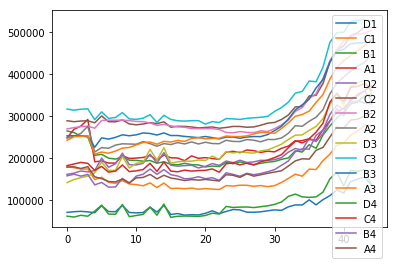

In [91]:
pd.DataFrame(region_intensity_dict['High Temp']).plot()

In [92]:
df_before = dict_before['qua72']
df_before.columns = col_li
df_before.index = range(1, len(df_before)+1)

In [98]:
df_high_q.index = range(1, 46)
df_high_q = df_high_q.reindex(sorted(df_high_q.columns), axis=1)

df_before_norm = (df_before - df_before.loc[10:20].mean())/(df_before.max()-df_before.loc[10:20].mean())
df_high_q_norm = (df_high_q-df_high_q.loc[10:20].mean())/(df_high_q.max()-df_high_q.loc[10:20].mean())

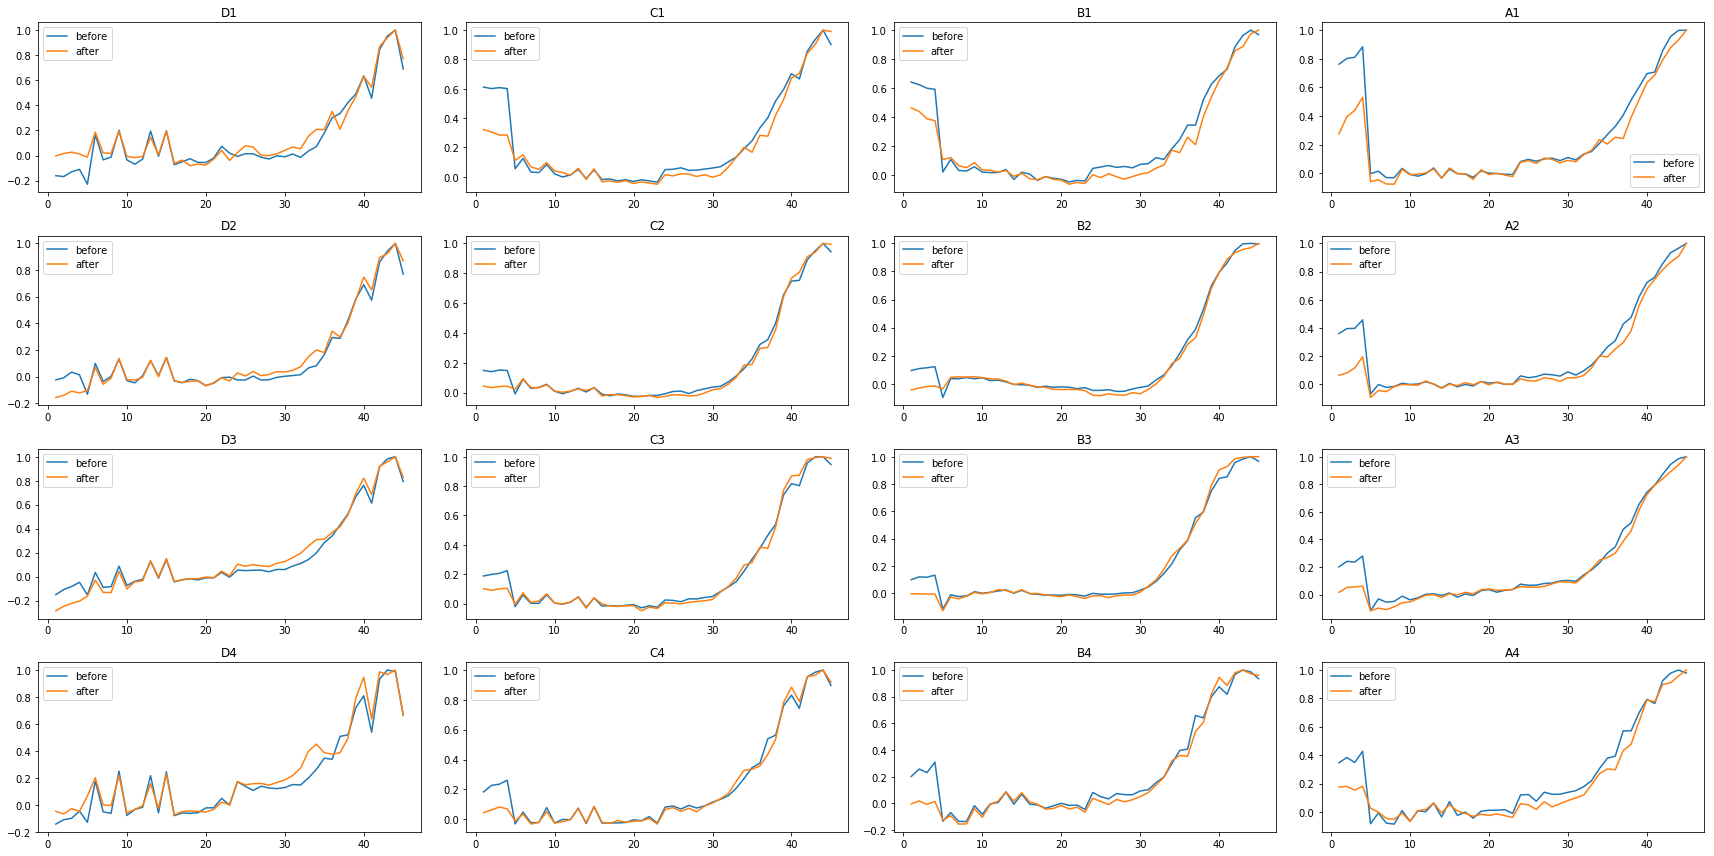

In [99]:
fig, axes = plt.subplots(4, 4, figsize=(24, 12))
n = 0
for col in df_before_norm.columns:
    i = n%4
    j = n//4
    axes[i, j].plot(df_before_norm[col], label='before')
    axes[i, j].plot(df_high_q_norm[col], label='after')
    axes[i, j].set_title(col)
    n += 1
    axes[i, j].legend(loc='best')
plt.tight_layout()
plt.savefig('compare_high_quasar_.png')
plt.show()

# Low Cal Red

In [62]:
pts_x = []
pts_y = []
for key, val in result_dict['well_grid']['Low Temp']['CalRed'].items():
    y1, x1, y2, x2 = val
    pts_x.extend([x1, x2])
    pts_y.extend([y1, y2])

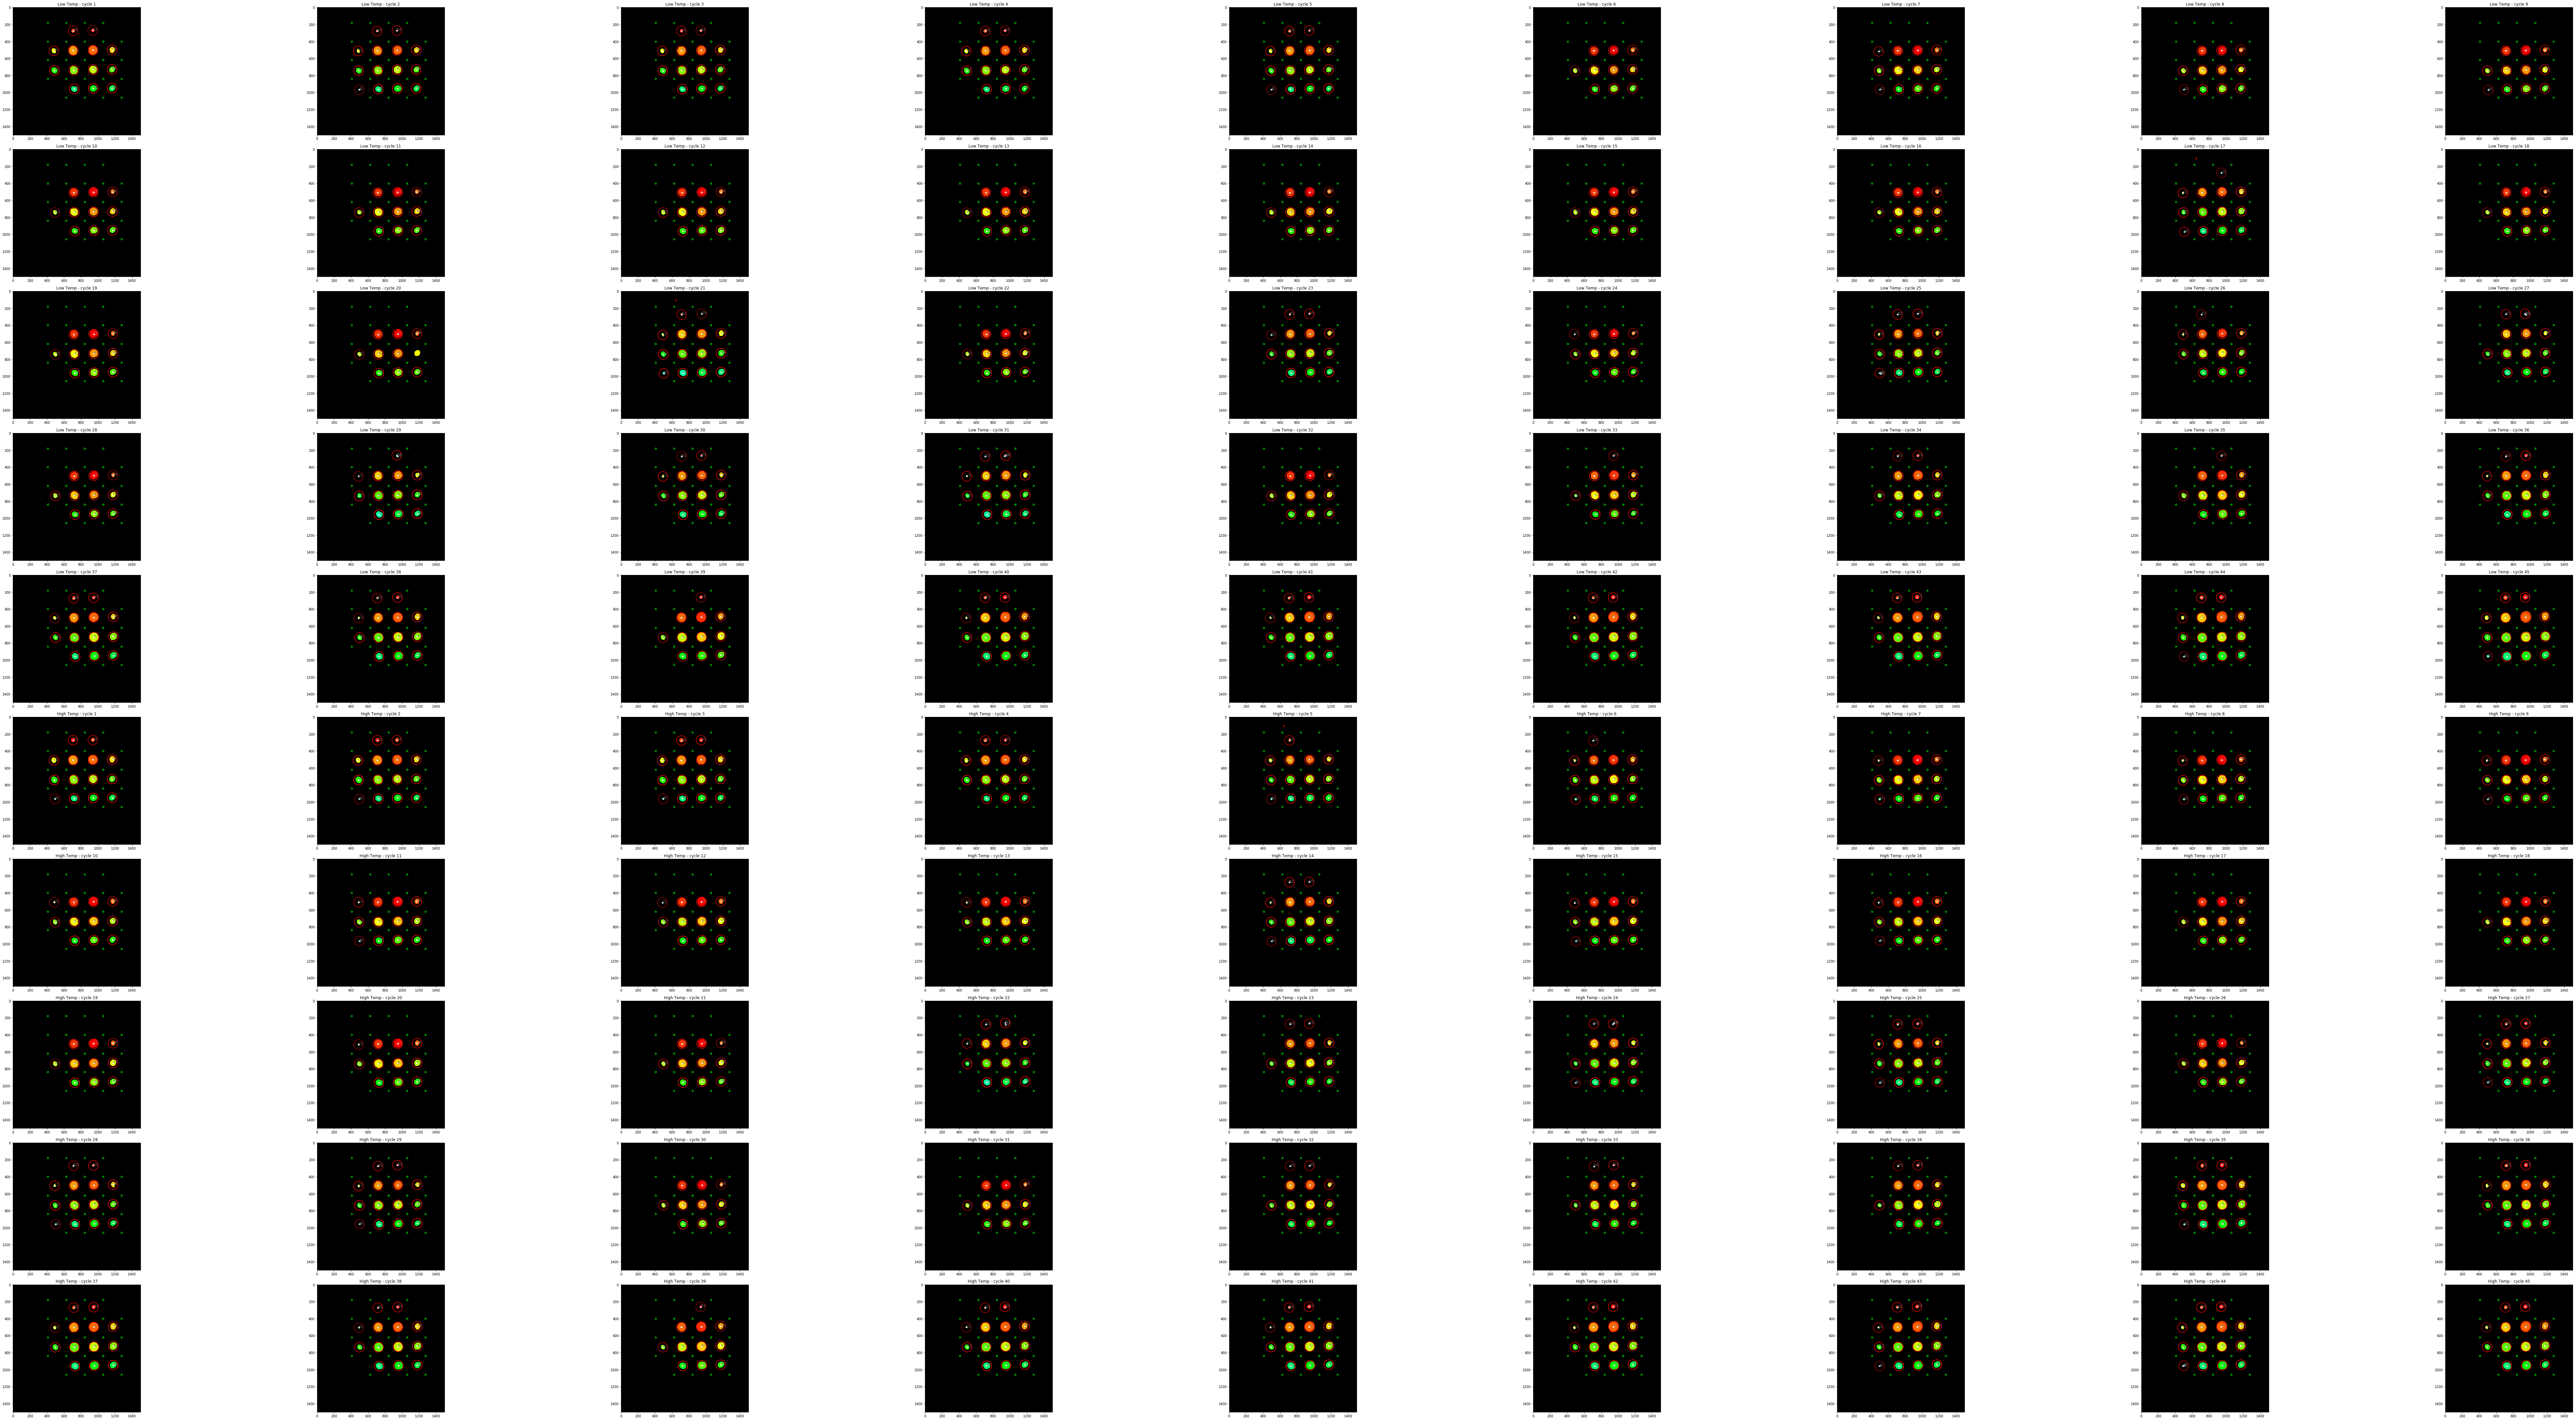

In [65]:
fig, ax = plt.subplots(10, 9, figsize=(24*5, 12*5))            
region_intensity_dict = {}
for t in range(2):
    region_intensity_dict[temp_li[t]] = {}
    for well in well_location_dict.keys():
        region_intensity_dict[temp_li[t]][well] = [0]*45

    for c in range(45):
        im_labeled = im_dict['CalRed'][temp_li[t]][c]['labeled']
        image_label_overlay = skimage.color.label2rgb(im_labeled, bg_label=0, colors=colors_li)
        ax_x_coord = c//9+(t*5)
        ax_y_coord = c%9

        ax[ax_x_coord, ax_y_coord].imshow(image_label_overlay)
        ax[ax_x_coord, ax_y_coord].set_title(f'{temp_li[t]} - cycle {c+1}')
        ax[ax_x_coord, ax_y_coord].scatter(pts_x, pts_y, c='g')

        sorted_region_key = list(im_dict['CalRed'][temp_li[t]][c]['regions'].keys())
        sorted_region_key.sort(reverse=True)

        center_at_cycle = {}
        circle_li = []
        for key in sorted_region_key:
            region_obj = im_dict['CalRed'][temp_li[t]][c]['regions'][key]
            y, x = region_obj.centroid
            grid = get_grid_loc(x, y, result_dict['well_grid'][temp_li[t]]['CalRed'])
            if grid is None:
                continue

            if grid not in center_at_cycle.keys():
                center = [x, y]
                center_at_cycle[grid] = center

                y_min, x_min, y_max, x_max = well_location_dict[grid]
                grid_center_x = (x_max-x_min)/2 + x_min
                rad = grid_center_x - x_min - 50
                circle_li.append(_patches.Circle(center, radius=rad, color='r', fill=False, linewidth=1))
            else:
                center = center_at_cycle[grid]
            well = get_well_loc(x, y, center, result_dict['well_grid'][temp_li[t]]['CalRed'])

            if well is not None:
                val = region_intensity_dict[temp_li[t]][well][c]
                val += region_obj.intensity_image.sum()
                region_intensity_dict[temp_li[t]][well][c] = val

                ax[ax_x_coord, ax_y_coord].plot(x, y, color='white', marker='*')
                ax[ax_x_coord, ax_y_coord].text(x, y, well, color='gray')
            else:
                ax[ax_x_coord, ax_y_coord].plot(x, y, color='b', marker='x')
            for circle in circle_li:
                ax[ax_x_coord, ax_y_coord].add_artist(circle)

plt.tight_layout()
plt.savefig('hsv_otsu_camera2_calRed_circle.png')
plt.show()

In [67]:
im_dict['CalRed'][temp_li[0]][7]['orig']

KeyError: 'orig'

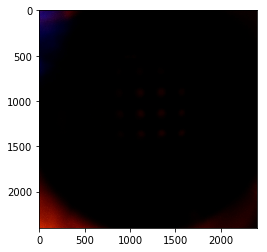

In [68]:
fpath = im_dir/'7_0_0.jpg'
im = np.array(Image.open(fpath))
plt.imshow(im)

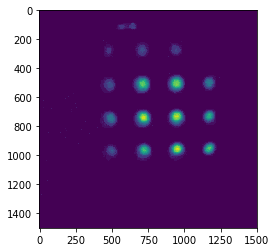

In [69]:
im_cropped = im[x_range, y_range]

im_hsv = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2HSV)
im_gray = im_hsv[:, :, 2]
plt.imshow(im_gray)

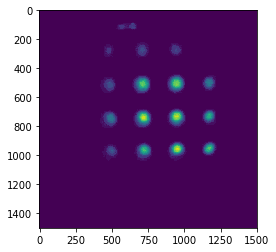

In [72]:
im_cropped = im[x_range, y_range]
plt.imshow(im_cropped[:, :, 0])

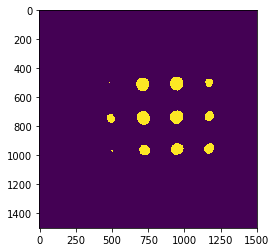

In [74]:
plt.imshow(im_dict['CalRed'][temp_li[0]][7]['thresh'])

# High HEX